In [31]:
# Import modules and packages
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import json
import pandas as pd
import re
from scipy.stats import gaussian_kde
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import unidecode
import unicodedata
%matplotlib inline

In [72]:
df = pd.read_csv('CompleteNBAPlayerLineupStats.csv')

df = df.groupby(['sorted_code'], as_index=False).filter(lambda s: s['name'].count() == 5)

df['MPGT'] = df['MPT']/df['GPT']

#min_GP = 40
#min_MPG = 10
min_GPT = 5
min_MPT = 30

df = df[df.GPT > min_GPT]
#df = df[df.MPT >= min_MPT]

#df['WAVG_OPP_FGP'].fillna(0, inplace=True)
#df[df.isna().any(axis=1)]
#print(df.columns[df.isna().any()].tolist())

df['cum_height'] = df.groupby(['sorted_code'], as_index=False)['height'].transform(sum)
df['cum_weight'] = df.groupby(['sorted_code'], as_index=False)['weight'].transform(sum)
df['cum_w_to_h'] = df['cum_weight']/df['cum_height']

#df.dropna(inplace=True)

print(df)


                     name pos team  year    GP    GS  height  weight  \
4659    Richard Jefferson  SF  CLE  2017  79.0  13.0    79.0   222.0   
4668    Richard Jefferson  SF  CLE  2017  79.0  13.0    79.0   222.0   
10708   Richard Jefferson  SF  CLE  2017  79.0  13.0    79.0   222.0   
10717   Richard Jefferson  SF  CLE  2017  79.0  13.0    79.0   222.0   
10927         Tony Parker  PG  SAS  2017  63.0  63.0    74.0   177.0   
...                   ...  ..  ...   ...   ...   ...     ...     ...   
185853        Tyler Herro  SG  MIA  2020  38.0   3.0    77.0   195.0   
185856        Tyler Herro  SG  MIA  2020  38.0   3.0    77.0   195.0   
185858        Tyler Herro  SG  MIA  2020  38.0   3.0    77.0   195.0   
185860        Tyler Herro  SG  MIA  2020  38.0   3.0    77.0   195.0   
185864        Tyler Herro  SG  MIA  2020  38.0   3.0    77.0   195.0   

         college country  ...  2PMT_PT   2PPT_PT  2PAT_PH 2PMT_PH   2PPT_PH  \
4659     Arizona     USA  ...     17.2  0.530864     40.

In [73]:
df_train = df[df.year.values < 2019].groupby(['sorted_code'], as_index=False).mean()
df_test = df[df.year.values == 2019].groupby(['sorted_code'], as_index=False).mean()
print(df_train)
print(df_test)
print("Using a training dataset of size:", len(df_train))
print("Using a test dataset of size:", len(df_test))


                                            sorted_code  year    GP    GS  \
0         AAbrinesARobersonCAnthonyJGrantRFeltonOKC2018  2018  71.0  25.6   
1      AAbrinesARobersonCAnthonyJGrantRWestbrookOKC2018  2018  70.6  41.2   
2      AAbrinesARobersonCAnthonyRWestbrookSAdamsOKC2018  2018  69.6  56.2   
3     AAbrinesARobersonDSabonisEKanterRWestbrookOKC2017  2017  76.2  46.4   
4      AAbrinesARobersonDSabonisEKanterSChristonOKC2017  2017  72.8  30.4   
...                                                 ...   ...   ...   ...   
1442        MConleyMGasolTAllenTDanielsZRandolphMEM2017  2017  70.8  43.2   
1443   MHarrellSDekkerSThornwellTWallaceWJohnsonLAC2018  2018  65.2  16.0   
1444  NStauskasRCovingtonRHolmesSRodriguezTLuwawu-Ca...  2017  68.2  32.0   
1445  NStauskasRCovingtonRHolmesTLuwawu-CabarrotTMcC...  2017  70.8  36.2   
1446    PGeorgePPattersonRFeltonRWestbrookSAdamsOKC2018  2018  79.8  48.0   

      height  weight  actual_draft_year  draft_round  draft_number  \
0    

In [144]:
#age,GP,GS,MPG,WLR,
###
#PTS_PT,FGM_PT,FGA_PT,FGP_PT,3PM_PT,3PA_PT,3PP_PT,FTM_PT,FTA_PT,FTP_PT,
#ORB_PT,DRB_PT,TRB_PT,AST_PT,TOV_PT,STL_PT,BLK_PT,PF_PT,PM_PT,
#PTS_OFF_TOV_PT,SEC_CHANCE_PTS_PT,FB_PTS_PT,PTS_PAINT_PT,BLK_ATTEMPT_PT,PF_DRAWN_PT,
#OPP_PTS_TOV_PT,OPP_PTS_2ND_PT,OPP_PTS_FB_PT,OPP_PTS_PAINT_PT,
###
#PTS_PH,FGM_PH,FGA_PH,FGP_PH,3PM_PH,3PA_PH,3PP_PH,FTM_PH,FTA_PH,FTP_PH,
#ORB_PH,DRB_PH,TRB_PH,AST_PH,TOV_PH,STL_PH,BLK_PH,PF_PH,PM_PH,
#PTS_OFF_TOV_PH,SEC_CHANCE_PTS_PH,FB_PTS_PH,PTS_PAINT_PH,BLK_ATTEMPT_PH,PF_DRAWN_PH,
#OPP_PTS_TOV_PH,OPP_PTS_2ND_PH,OPP_PTS_FB_PH,OPP_PTS_PAINT_PH,
#
#PERC_FGM,PERC_FGA,PERC_3PM,PERC_3PA,PERC_FTM,PERC_FTA,PERC_ORB,PERC_DRB,PERC_TRB,PERC_AST,PERC_TOV,PERC_STL,PERC_BLK,PERC_PTS,
#SCREEN_AST_PT,SCREEN_AST_PTS_PT,DEFL_PT,OFF_LB_RECOV_PT,DEF_LB_RECOV_PT,LB_RECOV_PT,PERC_OFF_LB_RECOV_PT,PERC_DEF_LB_RECOV_PT,CHARGE_DRAWN_PT,CONTESTS_2PT_PT,CONTESTS_3PT_PT,CONTESTS_PT,
#DIST_FEET_PG,DIST_M_PG,DIST_M_OFF,DIST_M_DEF,AVG_SPEED,AVG_SPEED_OFF,AVG_SPEED_DEF,
#
#FTR,EFGP,TS,ASTR,TOR,USG,ORR,DRR,REBR,PACE,PIE,OFFRTG,DEFRTG,NETRTG,OWS,DWS,WS,WS48,OBPM,DBPM,BPM,VORP,PER,VA,EWA
#ATR,2PM_PH,2PA_PH,2PP_PH,2PM_PT,2PA_PT,2PP_PT,2PR,3PR,ODRR,AVG_OPP_FGP,WAVG_OPP_FGP
#
#OFF_POSS_ISO,OFF_FREQ_ISO,OFF_PPP_ISO,OFF_FGP_ISO,OFF_EFGP_ISO,OFF_FT_FREQ_ISO,OFF_TO_FREQ_ISO,OFF_SF_FREQ_ISO,OFF_AND1_FREQ_ISO,OFF_SCORE_FREQ_ISO
#DEF_POSS_ISO,DEF_FREQ_ISO,DEF_PPP_ISO,DEF_FGP_ISO,DEF_EFGP_ISO,DEF_FT_FREQ_ISO,DEF_TO_FREQ_ISO,DEF_SF_FREQ_ISO,DEF_AND1_FREQ_ISO,DEF_SCORE_FREQ_ISO

#x_train = df_train[['PTS_PH', 'TS', 'ASTR', 'TOR', 'ORR', 'DRR', 'AVG_SPEED_OFF', 'AVG_SPEED_DEF', 'PACE', 'PF_PH', 'PF_DRAWN_PH', 'WAVG_OPP_FGP', 'CONTESTS_PT', 'LB_RECOV_PT', 'DEFL_PT']]
#y_train = df_train[['PM_PH']]
#x_test = df_test[['PTS_PH', 'TS', 'ASTR', 'TOR', 'ORR', 'DRR', 'AVG_SPEED_OFF', 'AVG_SPEED_DEF', 'PACE', 'PF_PH', 'PF_DRAWN_PH', 'WAVG_OPP_FGP', 'CONTESTS_PT', 'LB_RECOV_PT', 'DEFL_PT']]
#y_test = df_test[['PM_PH']]

# Features correlated with offensive rating
# PTS_PH (?), TS, PACE, ASTR OR ATR (?), TOR, LB_RECOV_PT, PF_DRAWN_PH, AVG_SPEED_OFF (?), PF_PH, ORR OR TRR (?)
#
# age, PTS_PH, TS, FTR, ASTR, TOR, ORR, DRR, REBR, LB_RECOV_PT, PTS_OFF_TOV_PH, SEC_CHANCE_PTS_PH, FB_PTS_PH, PTS_PAINT_PH, PF_DRAWN_PH, PACE, DIST_M_OFF, AVG_SPEED_OFF

#x_train = df_train[['age', 'cum_height', 'TST', 'ASTRT', 'TORT', 'ORBRT', 'DRBRT', 'TRBRT', 'LB_RECOV_PT', 'PTS_OFF_TOV_PH', 'SEC_CHANCE_PTS_PH', 'FB_PTS_PH', 'PTS_PAINT_PH', 'PFDT_PH', 'PACET', 'AVG_SPEED_OFF']]
#y_train = df_train[['OFFRTGT']]
#x_test = df_test[['age', 'cum_height', 'TST', 'ASTRT', 'TORT', 'ORBRT', 'DRBRT', 'TRBRT', 'LB_RECOV_PT', 'PTS_OFF_TOV_PH', 'SEC_CHANCE_PTS_PH', 'FB_PTS_PH', 'PTS_PAINT_PH', 'PFDT_PH', 'PACET', 'AVG_SPEED_OFF']]
#y_test = df_test[['OFFRTGT']]
x_train = df_train[['PTS_PH', '2PAT_PH', '3PAT_PH', 'FTAT_PH', 'TST', 'ASTRT', 'TORT', 'ORBRT', 'PTS_OFF_TOV_PH']]
y_train = df_train[['OFFRTGT']]
x_test = df_test[['PTS_PH', '2PAT_PH', '3PAT_PH', 'FTAT_PH', 'TST', 'ASTRT', 'TORT', 'ORBRT', 'PTS_OFF_TOV_PH']]
y_test = df_test[['OFFRTGT']]

# Features correlated with defensive rating
# PACE (?), LB_RECOV_PT (?), DEFL_PT, CONTESTS_PT, PF_PH, WAVG_OPP_FGP
#
# age, WAVG_OPP_FGP, WAVG_OPP_PPH, STL_PH, BLK_PH, BLK_ATTEMPT_PH, DEFL_PT, CHARGE_DRAWN_PT, CONTESTS_PT, OPP_PTS_TOV_PH, OPP_PTS_2ND_PH, OPP_PTS_FB_PH, OPP_PTS_PAINT_PH, PF_PH, PACE, DIST_M_DEF, AVG_SPEED_DEF

#x_train = df_train[['age', 'cum_height', 'WAVG_OPP_FGP', 'WAVG_OPP_PPH', 'STLT_PH', 'BLKT_PH', 'BLKAT_PH', 'DEFL_PT', 'CHARGE_DRAWN_PT', 'CONTESTS_PT', 'OPP_PTS_TOV_PH', 'OPP_PTS_2ND_PH', 'OPP_PTS_FB_PH', 'OPP_PTS_PAINT_PH', 'PFT_PH', 'PACET', 'DIST_M_DEF', 'AVG_SPEED_DEF']]
#y_train = df_train[['DEFRTGT']]
#x_test = df_test[['age', 'cum_height', 'WAVG_OPP_FGP', 'WAVG_OPP_PPH', 'STLT_PH', 'BLKT_PH', 'BLKAT_PH', 'DEFL_PT', 'CHARGE_DRAWN_PT', 'CONTESTS_PT', 'OPP_PTS_TOV_PH', 'OPP_PTS_2ND_PH', 'OPP_PTS_FB_PH', 'OPP_PTS_PAINT_PH', 'PFT_PH', 'PACET', 'DIST_M_DEF', 'AVG_SPEED_DEF']]
#y_test = df_test[['DEFRTGT']]

scale_tr = StandardScaler().fit(x_train)
x_train = scale_tr.transform(x_train)
scale_test = StandardScaler().fit(x_test)
x_test = scale_test.transform(x_test)


In [145]:
reg = LinearRegression()
reg.fit(x_train, y_train)
y_pred = reg.predict(x_test)
for i,pred in enumerate(y_pred):
    if 'GSW' in str(df_test.sorted_code.values[i]):
    #if 'Draymond Green' in str(df_test.code.values[i]):
        print(str(df_test.sorted_code.values[i]) + ' has a predicted +/- of ' + str(pred[0]) + ' compared to real +/- of ' + str(y_test.values[i][0]))

print('Made', len(y_pred), 'predictions with a RMS error of', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))


AIguodalaAMcKinnieDGreenKDurantKLooneyGSW2019 has a predicted +/- of 65.57638770734343 compared to real +/- of 72.4
AIguodalaAMcKinnieDGreenKDurantSCurryGSW2019 has a predicted +/- of 200.60907957394852 compared to real +/- of 215.2
AIguodalaAMcKinnieDGreenKLooneySCurryGSW2019 has a predicted +/- of 116.79993575855988 compared to real +/- of 122.0
AIguodalaAMcKinnieJJerebkoKLooneySCurryGSW2019 has a predicted +/- of 101.07716498257165 compared to real +/- of 106.1
AIguodalaAMcKinnieKDurantKLooneyQCookGSW2019 has a predicted +/- of 122.14945091342092 compared to real +/- of 125.6
AIguodalaAMcKinnieKDurantKLooneySCurryGSW2019 has a predicted +/- of 110.74821882553029 compared to real +/- of 114.2
AIguodalaDCousinsDGreenKThompsonSLivingstonGSW2019 has a predicted +/- of 106.45573869981763 compared to real +/- of 109.6
AIguodalaDCousinsKDurantKThompsonSCurryGSW2019 has a predicted +/- of 82.28020850248586 compared to real +/- of 86.1
AIguodalaDCousinsKThompsonQCookSLivingstonGSW2019 has a 

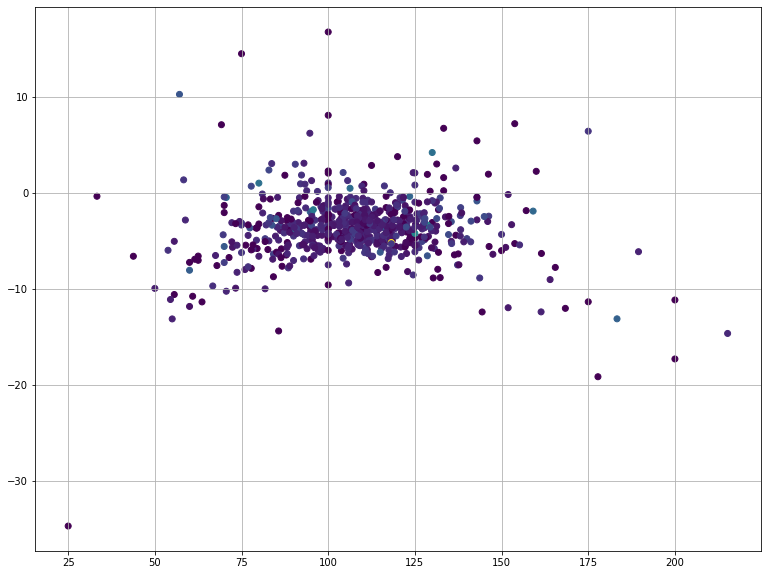

In [143]:
fig, ax = plt.subplots(1, 1, figsize=(13, 10))
#print(y_test.values[:,0], y_pred[:,0])
#print(df_test.TRBRT.values/df_test.TRBRT.values.max())
plt.title('')
plt.xlabel('')
plt.ylabel('')
#plt.scatter(y_test.values, y_pred-y_test.values, c=df_test.TRBRT.values/df_test.TRBRT.values.max())
plt.scatter(y_test, y_pred[:,0]-y_test.values[:,0], c=df_test['BLKT_PH'])
plt.grid()
#xmin, xmax = ax.get_xlim()
#ymin, ymax = ax.get_ylim()
#plt.plot([-150,150], [-150,150], 'r--')
#ax.set_xlim(xmin, xmax)
#ax.set_ylim(ymin, ymax)
#plt.axhline(0, linestyle='--', c='r')
#for i, txt in enumerate(df_test.sorted_code):
#    if 'GSW' in str(df_test.sorted_code.values[i]):
#        ax.annotate(txt, (y_test.values[i][0], y_pred[i]-y_test.values[i][0]))


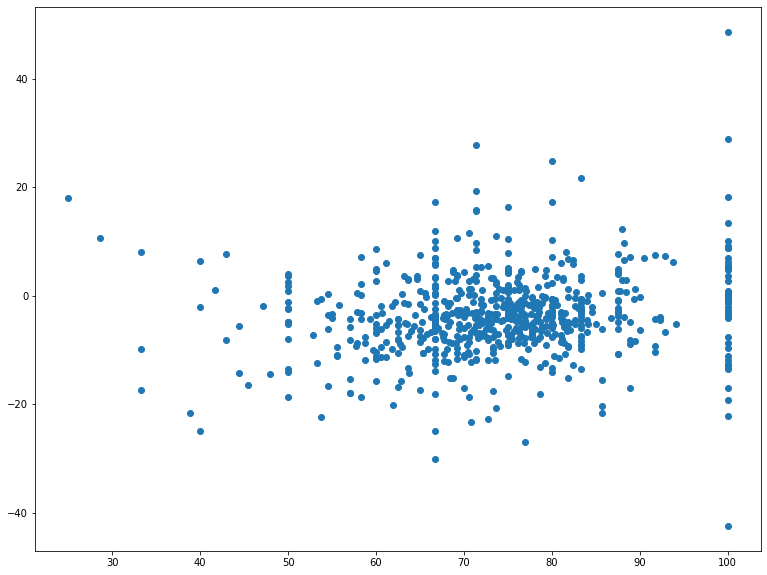

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(13, 10))
plt.scatter(df_test.DRBRT, y_pred-y_test.values)


In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(13, 10))
plt.title('')
plt.grid()
plt.scatter(df_test.OFFRTGT.values, y_pred-y_test.values)
plt.xlabel('')
plt.ylabel('')
#xmin, xmax = ax.get_xlim()
#ymin, ymax = ax.get_ylim()
#plt.plot([-150,150], [-150,150], 'r--')
#ax.set_xlim(xmin, xmax)
#ax.set_ylim(ymin, ymax)
#plt.axhline(0, linestyle='--', c='r')
for i, txt in enumerate(df_test.name):
    ax.annotate(txt, (df_test.OFFRTGT.values[i], y_pred[i]-y_test.values[i][0]))


In [37]:
ridge_reg = Ridge(alpha=0.1)
ridge_reg.fit(x_train, y_train.values.ravel())
y_ridge_pred = ridge_reg.predict(x_test)
for i,pred in enumerate(y_ridge_pred):
    print(str(df_test.sorted_code.values[i]) + ' has a predicted +/- of ' + str(pred) + ' compared to real +/- of ' + str(y_test.values[i][0]))

print('Made', len(y_ridge_pred), 'predictions with a RMS error of', np.sqrt(metrics.mean_squared_error(y_test, y_ridge_pred)))


Aaron Gordon has a predicted +/- of 106.53751159528447 compared to real +/- of 107.39999999999999
Aaron Holiday has a predicted +/- of 104.42602489815533 compared to real +/- of 107.2
Abdel Nader has a predicted +/- of 99.18278479846659 compared to real +/- of 96.4
Al Horford has a predicted +/- of 110.17966320126348 compared to real +/- of 112.5
Al-Farouq Aminu has a predicted +/- of 108.77510450350212 compared to real +/- of 116.29999999999997
Alex Len has a predicted +/- of 105.21820362177266 compared to real +/- of 106.0
Alfonzo McKinnie has a predicted +/- of 105.40532444968753 compared to real +/- of 108.8
Allen Crabbe has a predicted +/- of 105.03594325125205 compared to real +/- of 106.5
Andre Drummond has a predicted +/- of 106.70163568564544 compared to real +/- of 111.70000000000003
Andre Iguodala has a predicted +/- of 110.89766119579502 compared to real +/- of 113.39999999999999
Andrew Wiggins has a predicted +/- of 106.566527467371 compared to real +/- of 110.700000000000

In [ ]:
svr_reg = svm.SVR()
svr_reg.fit(x_train, y_train.values.ravel())
y_svr_pred = svr_reg.predict(x_test)
#print(y_svr_pred) 
for i,pred in enumerate(y_svr_pred):
    print(str(df_test.name.values[i]) + ' has a predicted +/- of ' + str(pred) + ' compared to real +/- of ' + str(y_test.values[i][0]))

print('Made', len(y_svr_pred), 'predictions with a RMS error of', np.sqrt(metrics.mean_squared_error(y_test, y_svr_pred)))


In [ ]:
mlp_reg = MLPRegressor()
mlp_reg.fit(x_train, y_train.values.ravel())
y_mlp_pred = mlp_reg.predict(x_test)
for i,pred in enumerate(y_mlp_pred):
    print(str(df_test.name.values[i]) + ' has a predicted +/- of ' + str(pred) + ' compared to real +/- of ' + str(y_test.values[i][0]))

print('Made', len(y_mlp_pred), 'predictions with a RMS error of', np.sqrt(metrics.mean_squared_error(y_test, y_mlp_pred)))
